<a href="https://colab.research.google.com/github/Boduck/Data-Analysis/blob/main/%EB%B0%98%EB%8F%84%EC%B2%B4_%EC%9D%B4%EC%83%81_%EA%B3%B5%EC%A0%95_%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **<반도체 이상 공정 탐지>**

---
> **분석목표**

```
1. 반도체 공정 프로세스 중 발생하는 센서 데이터로부터 반도체 공정의 Pass/Fail을 식별하기 위한 중요 변수 도출
2. 수율 이탈의 주요 원인 파악
3. 공정의 Pass/Fail 예측
```

> **예상 결과물**

```
1. 데이터 분석 기획서 (과제요건서)
2. Data Analysis 단계별 코드
3. 중요변수 도출
```

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks'

In [ ]:
# 필요 패키지 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1.과제요건서

<img src = "https://drive.google.com/uc?id=1A1Sz35J1jButl8y4bu2Fj4-ahkKFUAvo" height="400" width="700"/>

> **문제정의**

```
* 과도하게 많은 센서 데이터로 인한 중요 변수 선별 과정 부재
* 낮은 수율로 인한 비용 손실
* 데이터 수집 체계의 비효율성으로 인한 좁은 제조 데이터 Pool
```
> **기대 효과**

```
* 반도체 제조 공정의 품질과 효율성 향상
* 생산 비용 절감
* 수율 이탈률 저감
* 모니터링을 통해 주요 센서 교체 및 수리 시기 파악
```

> **해결 방안**

```
* 양품 및 불량을 결정 짓는 주요 변수 도출
* 공정에 주요한 영향을 주는 의미 있는 신호 파악
* 분류 모델을 통한 P/F 예측 - 불량 위험 알람?
```

> **우선순위**

```
1. 설명력을 고려하여 주요 변수 선별
2. 상관관계를 고려한 분류 모델링
```

# 2.Data Analysis
---

> **전처리**

```
① 중복 제거
* 초 단위에 의한 값의 차이로 추정되고 동일 시간대에 대한 중복 데이터의 수가 많지 않으므로, 평균값으로 대체하여 중복을 제거한다.
* 단, 종속변수인 Pass/Fail의 경우, 최빈값으로 대체

② 형 변환 및 상수 제거
* 각 컬럼을 속성에 맞게, 분석에 적합한 형태로 형 변환을 수행한다.
* 모든 데이터에 대해 같은 value를 가지는 컬럼은 삭제한다.

③ 결측치 처리
* 대체 혹은 삭제 과정을 통해 결측치를 처리하고자 한다.
* 과도하게 많은 결측치를 보유한 컬럼에 대해서는 별도로 저장하고, 본 프로젝트에서는 활용하지 않는다.

④ 표준화/정규화
* 표준화:표준정규분포의 속성을 갖도록 피처를 재조정
* 정규화:데이터셋의 수치형 변수의 범위 차이를 왜곡하지 않도록 공통 척도로 변경
* 변수 선택 과정 수행 전, 표준화를 통해 이상치의 영향을 줄인다.

```

> **중요 변수 파악**

```
1. 상관 관계가 높은 변수들을 식별
2. 다중공선성 제거 과정을 통해 변수 선별
3. Feature Importance
```

> **이상 탐지 모델링**

```
1. 차원 축소를 통하여 상관관계를 고려한 변수 추출
2. Logistic Regression, RandomForest, LightGBM 세 가지 모델링 및 성능 비교
3. 하이퍼파라미터 및 최적 모델 선정 주기 결정
```

## 2-1. 데이터 로드 및 EDA

데이터 설명 ⬇

|Column|Description|
|:---|:---|
|Time|측정시간|
|0~589|센서 데이터 Value|
|Pass/Fail|불량여부 (-1:불량, 1:양품)|

In [ ]:
df = pd.read_csv('uci-secom.csv')
df.head(3)

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1


- 분 단위의 시계열 데이터
- 센서 데이터 간 scale 범위가 크게 다름
- 많은 수의 변수들 중 핵심 신호를 선별해야함

In [ ]:
#Data형태,type확인. 종속변수의 범주별 데이터수 확인
print('데이터 형태 확인:\n', df.shape,'\n')
print('양품/불량 데이터 개수:\n',df['Pass/Fail'].value_counts(), '\n')
df.info()

데이터 형태 확인:
 (1567, 592) 

양품/불량 데이터 개수:
 -1    1463
 1     104
Name: Pass/Fail, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


- 문자형의 데이터 Time변수 외의 모든 컬럼은 숫자형 데이터
- 양품/불량 데이터의 불균형 확인
- Time변수를 datetime형으로 변환 후 인덱스로 전환하는 처리 과정 필요

## 2-2. 데이터 전처리
---
> ① 중복 제거

```
* 초 단위에 의한 값의 차이로 추정되고 동일 시간대에 대한 중복 데이터의 수가 많지 않으므로, 평균값으로 대체하여 중복을 제거한다.
* 단, 종속변수인 Pass/Fail의 경우, 최빈값으로 대체
```

> ② 형 변환 및 상수 제거

```
* 각 컬럼을 속성에 맞게, 분석에 적합한 형태로 형 변환을 수행한다.
* 모든 데이터에 대해 같은 value를 가지는 컬럼은 삭제한다.
```

> ③ 결측치 처리

```
* 대체 혹은 삭제 과정을 통해 결측치를 처리하고자 한다.
* 과도하게 많은 결측치를 보유한 컬럼에 대해서는 별도로 저장하고, 본 프로젝트에서는 활용하지 않는다.
```

> ④ 표준화/정규화

```
* 표준화:표준정규분포의 속성을 갖도록 피처를 재조정
* 정규화:데이터셋의 수치형 변수의 범위 차이를 왜곡하지 않도록 공통 척도로 변경
* 본 프로젝트에서는 표준화만 진행
```

### ① 중복 제거

In [ ]:
#1)시간 중복 확인
tmp = df[df.duplicated(subset='Time', keep=False)] # 초 단위에 차이가 있는 것으로 추정됨
print(f'\n{tmp.Time.nunique()}개의 시간데이터 중복이 존재')
print(f'중복 시간대 데이터 총 개수: {tmp.index.nunique()}행\n')

#2)종속변수에 대하여, 최빈값으로 대체
df_sub = df.copy()
df_sub['Pass/Fail'] = df_sub.groupby('Time')['Pass/Fail'].transform(lambda x: x.mode().iloc[0]) # 최빈값이 여러 개라면, 처음 값으로 대체

#3)그 외 컬럼 평균값으로 대체하여 중복 제거
df = df_sub.groupby('Time').mean().reset_index()
print(f'중복 제거 후 데이터 형태:\n{df.shape}\n')


32개의 시간데이터 중복이 존재
중복 시간대 데이터 총 개수: 65행

중복 제거 후 데이터 형태:
(1534, 592)



### ② 형 변환 및 상수 제거

In [ ]:
#양품/불량 데이터 및 시간대 확인
#copy할까..
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace = True)
print('데이터 시간 범위:\n',df.index.min(),'~',df.index.max(),'\n')
print(f'데이터 총 측정일수:\n{pd.Series(df.index.date).nunique()}일\n')
print('''
시간 데이터에 대해 datetime형 변환 수행
약 11개월의 기간 중 약 86일의 데이터만 존재함을 확인
즉, 데이터가 없는 구간이 존재함을 염두에 두고 분석 진행
''')

데이터 시간 범위:
 2008-01-08 02:02:00 ~ 2008-12-10 18:47:00 

데이터 총 측정일수:
86일


시간 데이터에 대해 datetime형 변환 수행
약 11개월의 기간 중 약 86일의 데이터만 존재함을 확인
즉, 데이터가 없는 구간이 존재함을 염두에 두고 분석 진행



In [ ]:
#전체 데이터에 대해서 값이 모두 동일한 컬럼 삭제(상수 제거)
df_mod = df.copy()

for col in df_mod.columns:
  if df_mod[col].nunique() == 1:
    df_mod.drop([col], axis=1, inplace=True)
print(f'총 {df.shape[1]-df_mod.shape[1]}개의 컬럼이 삭제됨')

총 116개의 컬럼이 삭제됨


### ③ 결측 처리

In [ ]:
print(f'\n전체 {df_mod.shape[0]}행의 데이터 중 결측치가 존재하는 데이터의 수는 {df_mod[df_mod.isnull().any(axis=1)].shape[0]}행')
print('종속변수의 결측치 수:', df_mod['Pass/Fail'].isnull().sum(),'\n')
print(f"0인 값을 가지는 데이터 수: {(df_mod== 0).sum().sum()}개\n")

########################결측치 수 구간별 컬럼 수 확인################################
missing_counts = df_mod.isnull().sum()

bins = [0, 50, 100, float('inf')]
labels = ['0-49', '50-99', '100+']
missing_bins = pd.cut(missing_counts, bins=bins, labels=labels, right=False)
missing_vc = missing_bins.value_counts().sort_index() #각 구간에 해당하는 컬럼 수 계산

result_df = pd.DataFrame(missing_vc, columns=['컬럼 수']) #결과를 데이터프레임으로 만들기
result_df.index.name = '결측 구간'
result_df


전체 1534행의 데이터 중 결측치가 존재하는 데이터의 수는 1534행
종속변수의 결측치 수: 0 

0인 값을 가지는 데이터 수: 24623개



,컬럼 수
결측 구간,
0-49,423
50-99,0
100+,52


-   종속변수에는 결측치가 존재하지 않음을 확인하였다.
-   모든 행에 대해 결측치가 존재하므로, 결측치가 있는 행 제거는 불가능하다.
-   측정값이 0인 데이터가 존재하므로, 결측치에 대하여 0으로 대체하는 방법은 배제한다.
-   결측치 수를 50개의 구간별로 나누어 컬럼별 결측치 보유 현황을 확인하였다.

  - 423개의 컬럼이 결측치의 수가 50개 미만으로 많지 않음을 알 수 있다.
  - 100개 이상의 결측치를 보유한 컬럼에 대해서는 별도의 데이터 프레임화하여 본 프로젝트에서는 활용하지 않는다.(추후에 따로 분석)




In [ ]:
#결측치100개 이상 컬럼 별도 저장(over100)
col_over100 = missing_counts[missing_counts >= 100].index
over100 = df_mod[col_over100]

#본 데이터프레임에서 삭제
tmp = df_mod.drop(col_over100, axis=1)

#중앙값 대체
df_final = tmp.fillna(tmp.median())

- 변수의 수가 많아 컬럼별 이상치 확인이 어렵고, 총 데이터 수에 비해 각 컬럼이 가지고 있는 결측치의 수가 많지 않음을 고려하였다.
- 결측치를 중앙값으로 대체(혹시 모를 이상치가 있을 것을 대비하여 평균 대신 중앙값 사용)

### ④ 표준화/정규화

In [ ]:
y = df_final[['Pass/Fail']]
X = df_final.drop(['Pass/Fail'], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#numpy ndarry로 반환되어 DataFrame으로 변환
df_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)

## 2-3. 핵심 변수 선택 및 시각화
---

1.  다중공선성 제거
    - 422개의 센서 데이터들 사이의 상관관계가 있을 것으로 판단
    - VIF가 10을 넘는 변수 제거
2.  Feature Importance
    - 어떤 특성이 예측에 가장 큰 영향을 미치는지를 파악
    - 특정 모델에 종속적이며, 모델의 종류에 따라 계산 방법이 다름
    - 특성 간의 인과관계를 명확히 알 수 없음
3.  Permutation Importance(수행X)
    - 데이터의 특성을 무작위로 섞고, 섞인 데이터를 모델에 넣어 성능 변화를 측정
    - 모델에 독립적이므로 어떤 모델이던 적용 가능하며, 모델의 예측 성능에 직접적으로 의존하지 않음.
4. 데이터 시각화
    - 연월 단위로 데이터를 구분하고 양품데이터가 가장 많은 날짜 구간에 대해 자세히 시각화
    - 다중공선성 제거&Feature Importance 두 과정 후 선별된 공통 변수 시각화
    - 다중공선성 제거 후 Feature Importance 수행 후 선별된 변수 시각화


### 다중공선성 제거

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):

    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif_data

def remove_high_vif_variables(df, threshold=10):

    vif_data = calculate_vif(df)
    high_vif_vars = vif_data[vif_data["VIF"] > threshold]["Variable"].tolist()

    while high_vif_vars:
        print(f"VIF이 10을 넘는 변수: {high_vif_vars}")
        df = df.drop(columns=high_vif_vars)
        vif_data = calculate_vif(df)
        high_vif_vars = vif_data[vif_data["VIF"] > threshold]["Variable"].tolist()

    print(f'\n제거 후 변수 개수:{df.shape[1]}개')

    return df

In [ ]:
# 다중공선성이 높은 변수를 제거
df_vif_removal = remove_high_vif_variables(df_scaled)

VIF이 10을 넘는 변수: ['0', '2', '3', '4', '11', '12', '14', '16', '17', '18', '19', '21', '22', '25', '26', '27', '28', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '43', '44', '45', '46', '47', '48', '50', '51', '53', '54', '56', '57', '60', '61', '62', '63', '64', '65', '66', '67', '68', '70', '74', '86', '89', '90', '92', '93', '94', '96', '98', '99', '100', '104', '105', '106', '114', '115', '117', '119', '120', '121', '122', '123', '124', '127', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '142', '143', '144', '145', '146', '147', '148', '150', '151', '152', '153', '154', '155', '156', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '180', '181', '182', '183', '184', '185', '187', '188', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22

### Feature Importance

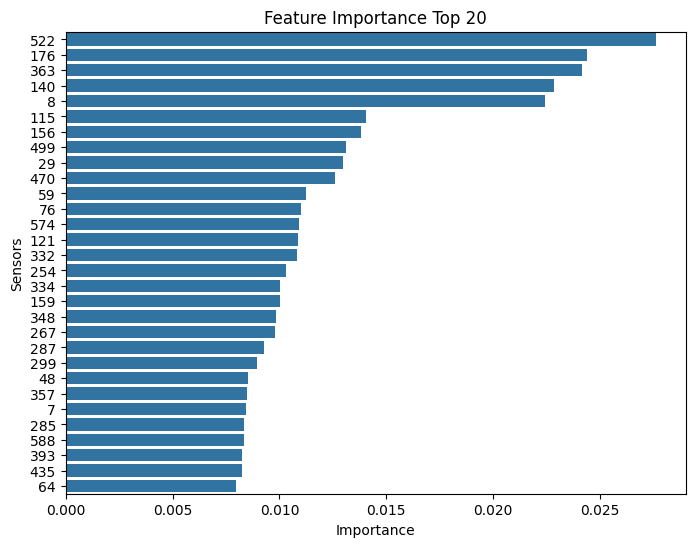

In [ ]:
#feature importance
from xgboost import XGBClassifier

model = XGBClassifier(random_state=11)
y_ = y.replace(-1,0)
model.fit(X, y_)

# 배열형태로 반환
ft_importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
n = 30 #시각화하고싶은 변수 개수
ft_series = pd.Series(ft_importance_values, index = X.columns)
ft_top30 = ft_series.sort_values(ascending=False)[:n]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
plt.xlabel('Importance')
plt.ylabel('Sensors')
sns.barplot(x=ft_top30, y=ft_top30.index)
plt.show()

In [ ]:
#Feature Importance 기준 주요 30개의 변수
ft_top30.index

Index(['522', '176', '363', '140', '8', '115', '156', '499', '29', '470', '59',
       '76', '574', '121', '332', '254', '334', '159', '348', '267', '287',
       '299', '48', '357', '7', '285', '588', '393', '435', '64'],
      dtype='object')

feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 하고싶다

In [ ]:
# 두 방법에 의해 선택된 공통된 변수 확인
list1=ft_top30.index.tolist()
list2=df_vif_removal.columns
common_elements = set(list1) & set(list2)
result_list = list(common_elements)
print(result_list)

['59', '499', '8', '76', '7', '29']


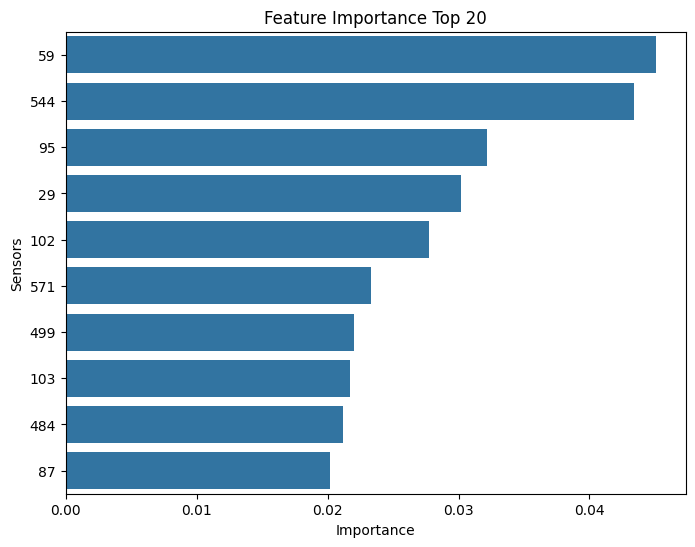

In [ ]:
#다중공선성 제거 후 Feature Importance

model = XGBClassifier(random_state=11)
# y_ = y.replace(-1,0)
model.fit(df_vif_removal, y_)

# 배열형태로 반환
ft_importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
n = 10 #시각화하고싶은 변수 개수
ft_series = pd.Series(ft_importance_values, index = df_vif_removal.columns)
ft_top10 = ft_series.sort_values(ascending=False)[:n]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
plt.xlabel('Importance')
plt.ylabel('Sensors')
sns.barplot(x=ft_top10, y=ft_top10.index)
plt.show()

In [ ]:
# 앞서 선별된 공통변수(result_list) 외 변수들
vr_fi = ft_top10.index.tolist()
vr_fi_vars = [item for item in vr_fi if item not in result_list]
print(vr_fi_vars)

['544', '95', '102', '571', '103', '484', '87']


### 데이터 시각화
---
양품데이터와 불량데이터 간의 관계를 확인하고자 한다.

1. 시각화 전 탐색: 데이터의 수가 현저히 적은 양품데이터를 고려하여, 연월 단위로 데이터를 구분하고 양품데이터가 가장 많은 날짜 구간에 대해 자세히 시각화한다.

2. 시각화: 스케일링되지 않은 데이터를 활용하고, 앞서 진행한 변수 선택 과정에서 선별된 변수들 중심으로 시각화를 진행한다.



---
> **1. 시각화 전 탐색**

In [ ]:
#월별 양품/불량 빈도수 확인
tmp = df_final.copy()
tmp['year_month'] = tmp.index.to_period('M')
tmp.groupby('year_month')['Pass/Fail'].value_counts().unstack(fill_value=0)

Pass/Fail,-1.0,1.0
year_month,,
2008-01,48,3
2008-02,90,5
2008-03,47,1
2008-04,46,3
2008-05,55,5
2008-06,60,6
2008-07,97,16
2008-08,421,37
2008-09,391,17


- 상대적으로 양품 데이터가 많이 몰려있는 7~9월 데이터를 면밀히 살펴보자
- 양품 데이터는 빨간색으로 표현한다
    - 불량(회색): 다중공선성 제거&Feature Importance 두 과정 후 선별된 공통 변수 시각화
    - 불량(푸른색): 다중공선성 제거 후 Feature Importance 수행 후 선별된 변수 시각화

---
> **2. 시각화**

In [ ]:
tmp2 = tmp.loc[(tmp['year_month']>='2008-07')&(tmp['year_month']<='2008-10')]

#양품/불량 데이터 분리
well = tmp2.loc[(tmp2['Pass/Fail']==1)]
fail = tmp2.loc[(tmp2['Pass/Fail']==-1)]

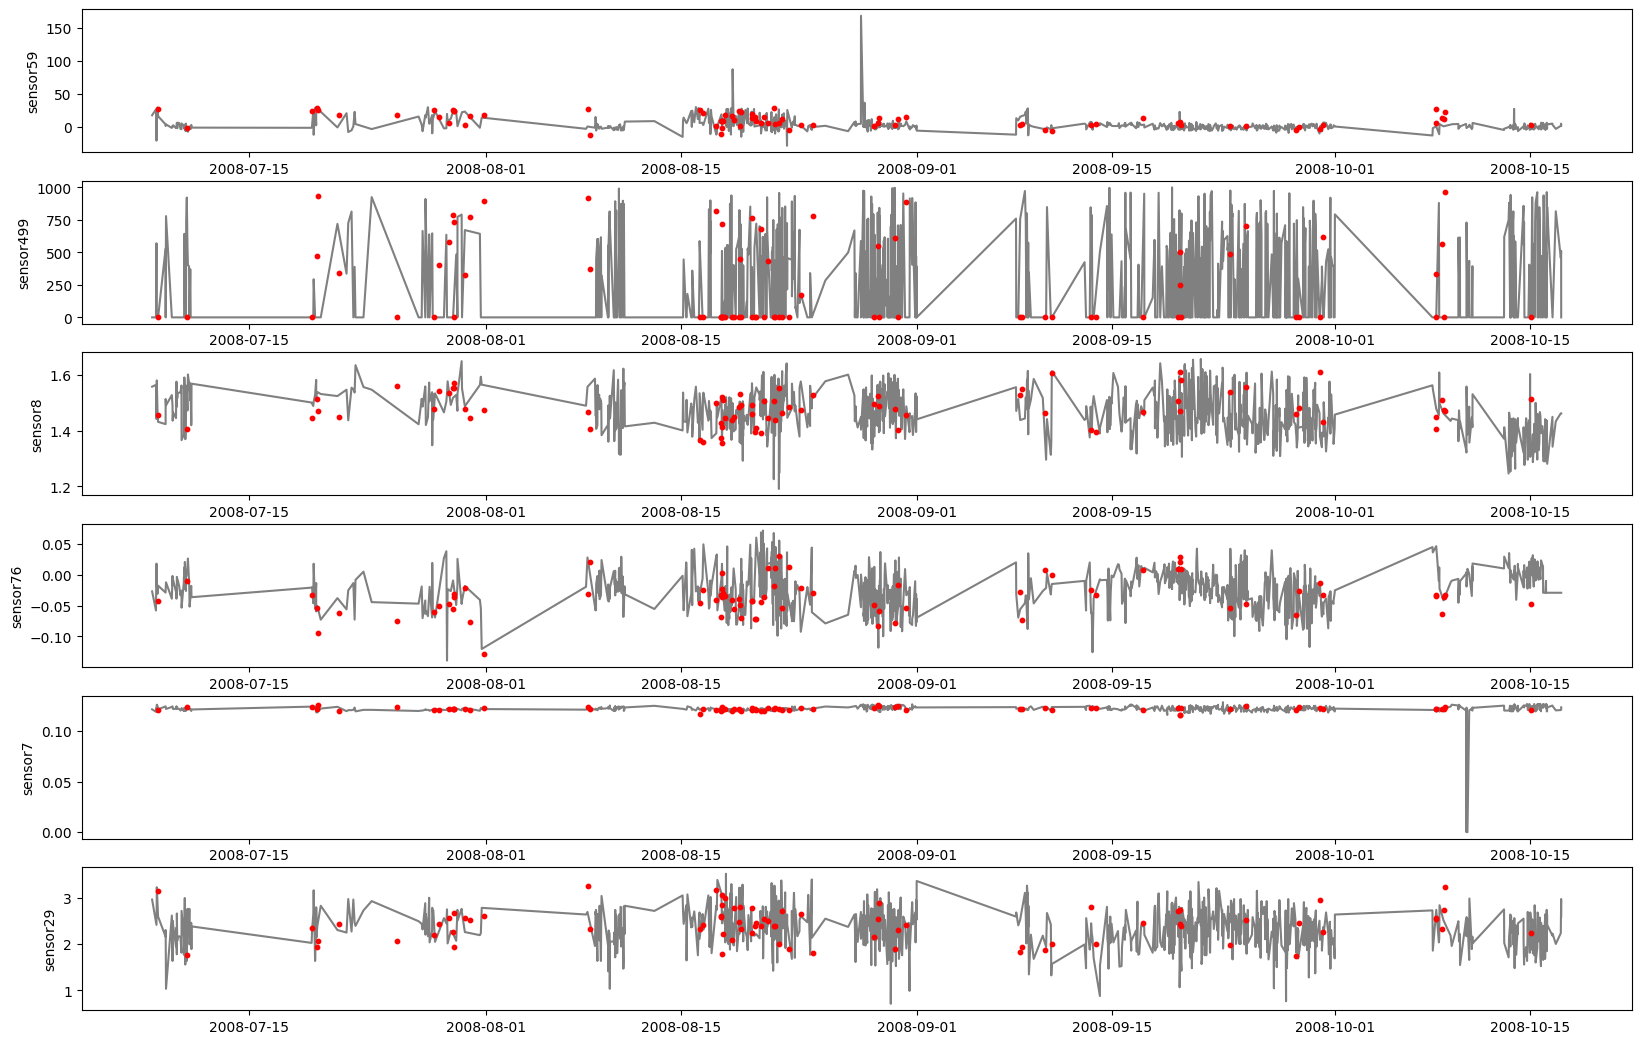

In [ ]:
#다중공선성 제거&Feature Importance 두 과정 후 선별된 공통 변수 시각화
fig, axes = plt.subplots(len(result_list), 1, figsize=(20, 13))
for v, i in  enumerate(result_list):
  axes[v].plot(fail.index ,fail[[i]], color='grey')
  axes[v].scatter(well.index, well[i], color='red', marker='o', zorder=2, s=10)
  axes[v].set_ylabel('sensor'+i)

- Sensor59의 경우, 좁은 범위에서 변동하는 반면, 큰 변동폭을 보이는 불량 데이터의 양상을 확인할 수 있다.
- Sensor499의 경우, 불량 데이터가 양품 데이터에 비해 작은 변동폭을 보이는 것으로 추정된다.(데이터 수 부족)

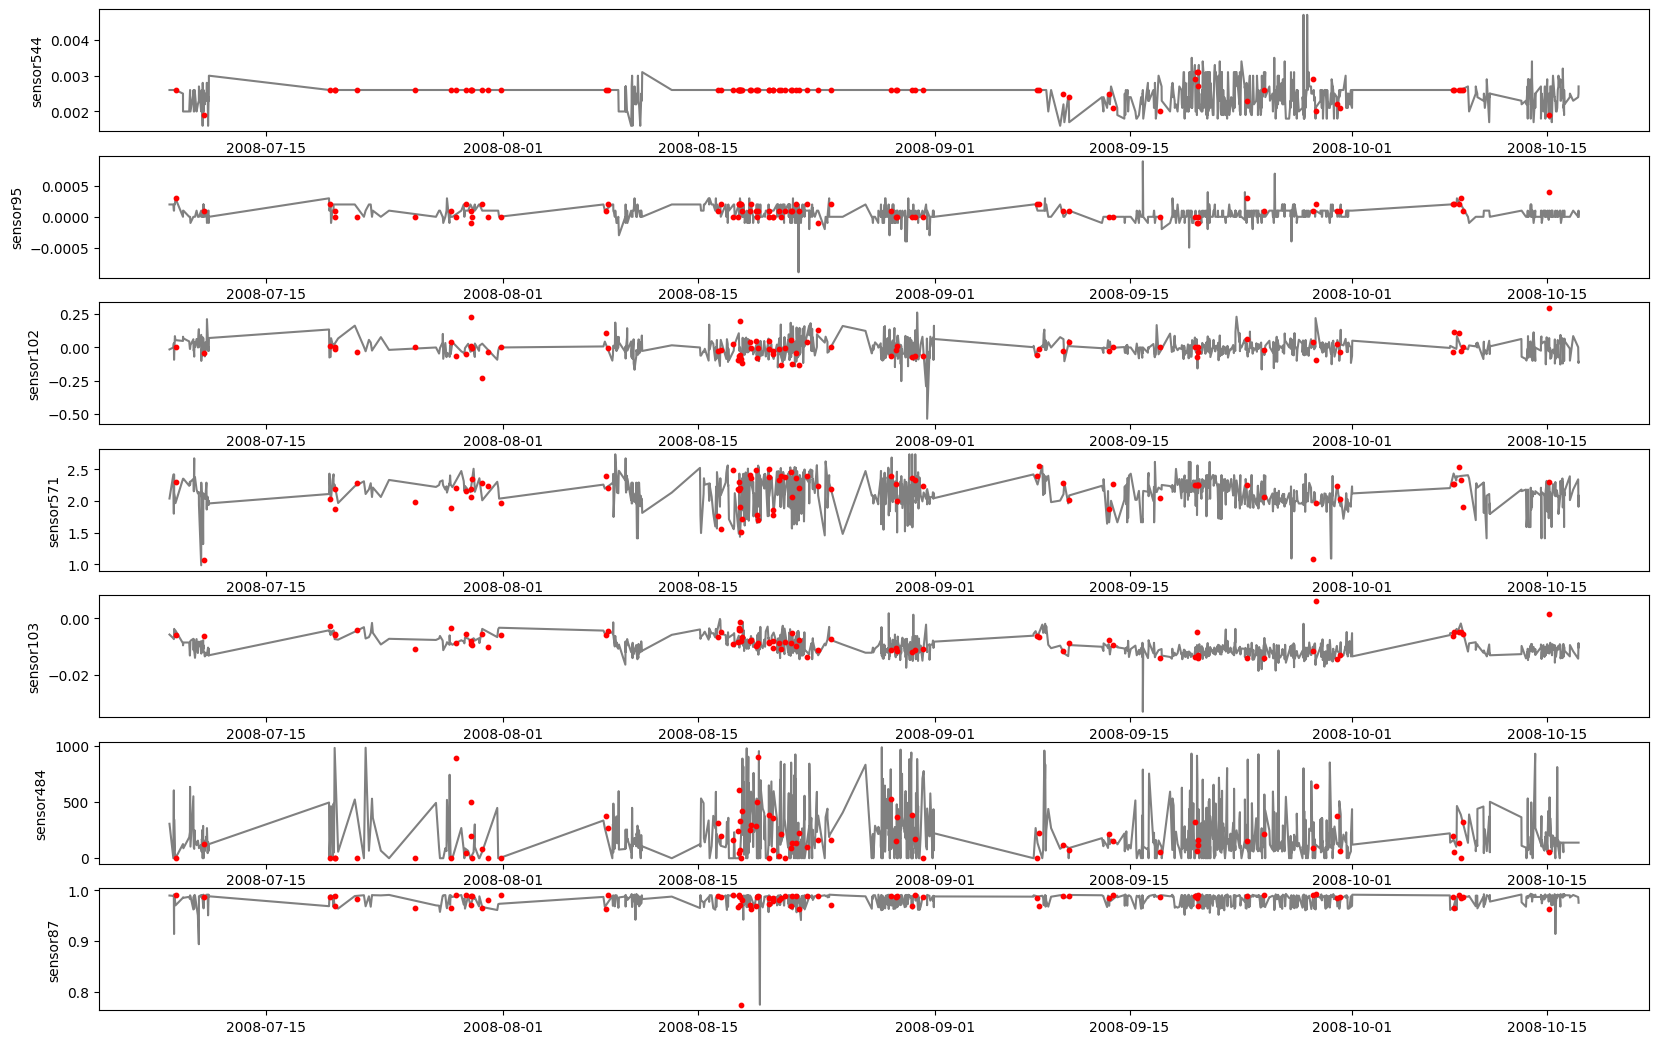

In [ ]:
#다중공선성 제거 후 Feature Importance 수행 후 선별된 변수 시각화
fig, axes = plt.subplots(len(vr_fi_vars), 1, figsize=(20, 13))
for v, i in  enumerate(vr_fi_vars):
  axes[v].plot(fail.index ,fail[[i]], color='grey')
  axes[v].scatter(well.index, well[i], color='red', marker='o', zorder=2, s=10)
  axes[v].set_ylabel('sensor'+i)

- Sensor544의 경우, 일정한 값을 유지하다 변동이 생기면 불량률이 증가하는 것으로 판단됨.
- Sensor '95', '102', '571', '103', '484', '87' 모두 불량 데이터의 변동폭이 양품데이터보다 눈에 띄게 큰 것으로 보인다.
- 일정 범주를 벗어날 경우, 불량 위험 신호로 판단

## 2-4. 이상 탐지 분류 모델링
---
> **Model Selection (classification)**

```
* 로지스틱 모델 (logistic regression)
* Tree 계열 Classification 모델
  - bagging 앙상블 (Randomforest)
  - boosting 앙상블 (lightGBM)
```
> **Model 학습**

```
* Model Selection 단계에서 선정한 모델들을 학습하고 성능을 기록
* 동일한 Data set, 동일한 환경에서 동일한 비교 지표로 성능을 비교
```

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

### Feature Engineering
---
```
1.   변수선택(Feature Selection)
    - 상관관계 고려가 어렵다
    - 해석이 용이
2.   변수추출(Feature Extraction)
    - 상관관계를 고려한다
    - 추출된 변수 해석이 어렵다
```
변수의 수가 많고, 유기적인 관계의 센서데이터들을 고려하기 위해 상관관계를 고려한 변수 추출을 수행

즉, PCA 적용하여 Feature Extraction을 시행한다.

In [ ]:
#스케일에 민감하므로, 표준화된 데이터를 활용하여 PCA
from sklearn.decomposition import PCA

In [ ]:
#PCA 모델 초기화 및 차원 축소
n_components = 10  # 축소할 차원 수를 지정
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

#축소된 차원의 데이터를 새로운 데이터프레임으로 만들기 (선택 사항)
columns_pca = [f'PC{i}' for i in range(1, n_components + 1)]
df_pca = pd.DataFrame(data=X_pca, columns=columns_pca)

#결과 출력
#print("PCA를 사용한 차원 축소된 데이터프레임:")
#print(df_pca)

In [ ]:
#학습 데이터, 테스트 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

### Modeling

In [ ]:
# 로지스틱 회귀 모델 학습 및 평가
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
y_pred_logistic = logistic_reg.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("\n로지스틱 회귀 정확도:", accuracy_logistic)

# RandomForestClassifier 모델 학습 및 평가
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nRandomForest 정확도:", accuracy_rf)

# LightGBM 모델 학습 및 평가
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("\nLightGBM 정확도:", accuracy_lgbm)


로지스틱 회귀 정확도: 0.9283387622149837

RandomForest 정확도: 0.9315960912052117
[LightGBM] [Info] Number of positive: 81, number of negative: 1146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1227, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066015 -> initscore=-2.649584
[LightGBM] [Info] Start training from score -2.649584

LightGBM 정확도: 0.9250814332247557


# 3.Performace Monitoring

In [ ]:
print(f'''
데이터 처리 과정을 통하여 불필요 변수 제거함으로써 기존 {df.shape[1]}개의 변수를 {df_mod.shape[1]}로 줄였다.
다중공선성 제거로 선별된 주요 변수의 개수는 {df_vif_removal.shape[1]}개
Feature Importance로 분류 모델을 활용한 선별된 중요 변수의 개수는 {n}개
두 방법의 공통 주요 변수 개수는 {len(result_list)}개
두 방법을 모두 시행해 선별된 중요 변수는 {len(vr_fi)}개

선별된 중요 변수들 시각화를 통해 판단한 중요 센서 변수들은 {result_list+vr_fi_vars}로,
총 {len(result_list+vr_fi_vars)}개의 변수가 선별되었다.
''')


데이터 처리 과정을 통하여 불필요 변수 제거함으로써 기존 591개의 변수를 475로 줄였다.
다중공선성 제거로 선별된 주요 변수의 개수는 73개
Feature Importance로 분류 모델을 활용한 선별된 중요 변수의 개수는 10개
두 방법의 공통 주요 변수 개수는 6개
두 방법을 모두 시행해 선별된 중요 변수는 10개

선별된 중요 변수들 시각화를 통해 판단한 중요 센서 변수들은 ['59', '499', '8', '76', '7', '29', '544', '95', '102', '571', '103', '484', '87']로,
총 13개의 변수가 선별되었다.



In [ ]:
print("로지스틱 회귀 분류 보고서:\n", classification_report(y_test, y_pred_logistic))
print("RandomForest 분류 보고서:\n", classification_report(y_test, y_pred_rf))
print("LightGBM 분류 보고서:\n", classification_report(y_test, y_pred_lgbm))

로지스틱 회귀 분류 보고서:
               precision    recall  f1-score   support

        -1.0       0.93      0.99      0.96       287
         1.0       0.00      0.00      0.00        20

    accuracy                           0.93       307
   macro avg       0.47      0.50      0.48       307
weighted avg       0.87      0.93      0.90       307

RandomForest 분류 보고서:
               precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       287
         1.0       0.00      0.00      0.00        20

    accuracy                           0.93       307
   macro avg       0.47      0.50      0.48       307
weighted avg       0.87      0.93      0.90       307

LightGBM 분류 보고서:
               precision    recall  f1-score   support

        -1.0       0.93      0.99      0.96       287
         1.0       0.00      0.00      0.00        20

    accuracy                           0.93       307
   macro avg       0.47      0.49      0.48       307
weighted avg     

# 4.결론 및 향후 계획
---
> Conclusion

```
- 주요 변수들이 일정 범주를 벗어날 경우, 불량 위험 신호로 판단
- 주요 변수별 정상 범주를 설정하는 기준 마련 필요 -> 추후 프로젝트 개진 가능
- 양품 데이터 수집이 늘어날수록 모델 성능이 향상될 것으로 기대됨
- 결측치가 많아 제외되었던 변수에 대한 추가 분석 프로젝트 시행
- 데이터 Pool이 넓어진 후, SMOTE를 활용한 데이터 불균형 해소 전처리 과정 추가
```

> Model Operation

```
- 내부 리소스 및 효율성 측면을 고려하여 업데이트 주기 설정
- 새로 유입이 되는 변수들에 대해 연마다 최적의 모델 선정
- 월마다 모델의 최적의 파라미터 선정
```